In [1]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=2*np.random.random(input_len)-1
    elif(1==input_type): 
        input_raw=np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.8-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.0*input_raw[i]**2+ 1.0*input_raw[i-3]**2
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+1.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-1.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def PNFIR_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        #for ii in range(M_num-1,-1,-1):   # external_input(r) 
        for ii in range(0,M_num):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        #if(0==i%100): 
            #print('output_modul:',output_modul[:,i])
            #print('dif_output_modul:',dif_output_modul)
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a
def PNFIR_model_zhao(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a

apoch: 0 PNFIR -22.564017238254905 dB -21.240259969479744 dB
apoch: 50 
 mean_MSE: PNFIR 0.006069088046597133 -22.16876561986561 dB 
 0.008045451784021553 -20.944495635228684 dB


C:\Users\Administrator\AppData\Local\Temp/ipykernel_11732/1272310090.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='green',label="PNFIR02",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_11732/1272310090.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)


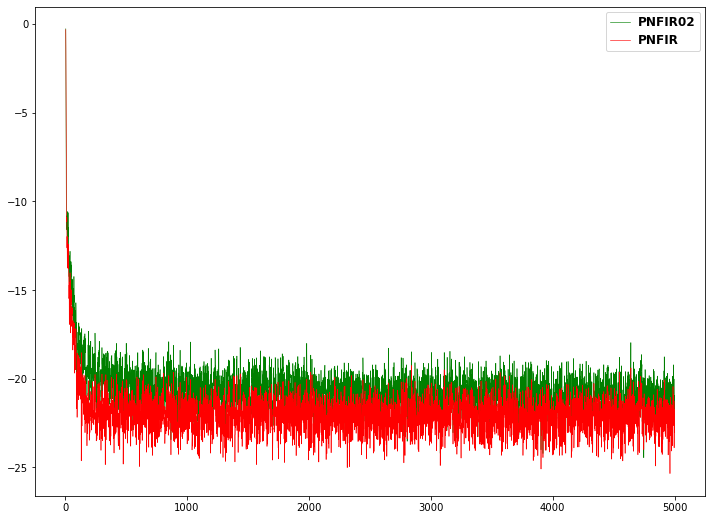

In [2]:
N = 5000; M=5; p=1; apoch=50
train_para=np.array([0.6,0.001,0.6,0,0]) 
error2_sum_PNFIR=np.zeros(N);
error2_sum_PNFIR02=np.zeros(N);
for times in range(0,apoch): 
    x_raw,d_raw,d_noise=input_set(1,1,N,1)    #  random
    #x_raw,d_raw,d_noise=input_set(1,0,N,1)    #  gaussian
    output_filter,error_PNFIR,weight_lin01,weght_non01,value_a01=PNFIR_model(x_raw,d_raw,M,p,train_para)  #PNFIR
    output_filter,error_PNFIR02,weight_lin02,weght_non02,value_a02=PNFIR_model_zhao(x_raw,d_noise,M,p,train_para)  #PNFIR
    error2_sum_PNFIR+=error_PNFIR**2
    error2_sum_PNFIR02+=error_PNFIR02**2
    if(0==times%50):
        print('apoch:',times,'PNFIR',10*np.log10(np.mean(error_PNFIR[-100:]**2)),'dB',\
              10*np.log10(np.mean(error_PNFIR02[-100:]**2)),'dB'
             )
error2_sum_PNFIR/=apoch;
error2_sum_PNFIR02/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','PNFIR',np.mean(error2_sum_PNFIR[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR[-106:-6])),'dB',\
     '\n',np.mean(error2_sum_PNFIR02[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR02[-106:-6])),'dB'
     )
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='green',label="PNFIR02",linewidth=0.6)
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

# blew is GSA for PNFIR filters

In [ ]:
def PNFIR_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        #for ii in range(M_num-1,-1,-1):   # external_input(r) 
        for ii in range(0,M_num):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        #if(0==i%100): 
            #print('output_modul:',output_modul[:,i])
            #print('dif_output_modul:',dif_output_modul)
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a

In [4]:
problem = {
    'num_vars': 5,
    'names': ['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4',     
             ],
    'bounds': [
               [0,1],[0,1],[0,1],[0,1],[0,1],   
               ] }
factor_num = problem['num_vars']
def SA_model(module_num,p_num,weight_linear,weight_nonlin,value_a,X):
    inputlen=p_num+1;
    input_module = np.zeros(module_num*inputlen).reshape(module_num,inputlen);
    external_input = np.zeros(module_num);
    output_modul = np.zeros(module_num*(len(X))).reshape(module_num,len(X)); output_nonlin = np.zeros_like(output_modul)
    output_linear = np.zeros(len(X))
    output_filter = np.zeros(len(X))
    for j in range(0,len(X)):
        for jj in range(0,module_num):
            if(jj==(module_num-1)):
                external_input[jj]=output_nonlin[0,j-1]
            else :
                external_input[jj]=output_nonlin[jj+1,j]
            for jjj in range(1,p_num+1):
                input_module[jj,jjj-1]=X[j,p_num*jj+jjj-1] # p input
            input_module[jj,p_num]  = external_input[jj]
            output_modul[jj,j]=np.dot(weight_nonlin[jj,:],input_module[jj,:].T)
            output_nonlin[jj,j]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[jj,j]))))     
        output_linear[j]=np.dot(weight_linear,output_nonlin[:,j].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[j]=lambda_a*output_linear[j]+(1-lambda_a)*(sum(output_modul[:,j]))    
    return output_filter       

In [5]:
for k in range(1,1):
    print(k)
weght_non02,X_efast.shape

NameError: name 'X_efast' is not defined

In [6]:
# EFAST method
from SALib.analyze import fast;from SALib.sample import fast_sampler
module_number=5;p=1; circle = 1; 
Si_efast_first= np.zeros(circle*factor_num).reshape(circle,factor_num);
Si_efast_total=np.zeros_like(Si_efast_first)
sum_first= np.zeros(factor_num); avg_sen_first = np.zeros(factor_num); 
sum_total= np.zeros(factor_num); avg_sen_total = np.zeros(factor_num);
for i in range(0,circle):
    X_efast = fast_sampler.sample(problem, 10000)
    Y_efast = SA_model( module_number,p,weight_lin01,weght_non01,value_a01,X_efast[:,:factor_num])
    if(i==circle-1): Si_efast = fast.analyze(problem, Y_efast, print_to_console=False)
    else : Si_efast = fast.analyze(problem, Y_efast, print_to_console=False)
    Si_efast_df = (Si_efast.to_df()).values
    Si_efast_first[i,:] = Si_efast_df[:,0]
    Si_efast_total[i,:]  = Si_efast_df[:,1]
    for ii in range(0,factor_num):
        sum_first[ii] = sum_first[ii]+Si_efast_first[i,ii]
        sum_total[ii] = sum_total[ii]+Si_efast_total[i,ii]
for j in range(0,factor_num):
    avg_sen_first[j]=sum_first[j]/circle
    avg_sen_total[j]=sum_total[j]/circle

sum(avg_sen_first),(avg_sen_first[0]+avg_sen_first[3])/sum(avg_sen_first[:]),\
sum(avg_sen_total),(avg_sen_total[0]+avg_sen_total[3])/sum(avg_sen_total[:])

(0.9774441501642959,
 0.9885099197412512,
 0.9812791846653479,
 0.9869151193200054)

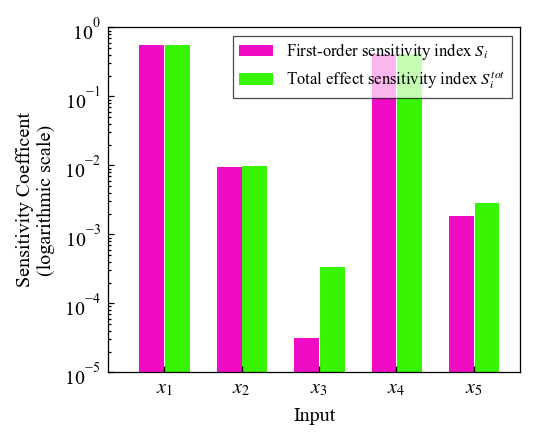

In [8]:
import matplotlib as mpl;import matplotlib.pyplot as plt;
import matplotlib.font_manager as fm;from matplotlib.ticker import MultipleLocator,AutoMinorLocator
# 图片大小,单位厘米
#fw = 17/2.54; fh = 7.38/2.54
fw = 8.69/2.54; fh = 7.18/2.54 
# 设置全局的字体
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.stretch'] ='normal'
mpl.rcParams['font.size'] = 9   
plt.rcParams['mathtext.fontset'] = 'stix' 
font0 = {'fontfamily': 'serif',
         'fontname': 'Times New Roman',
         'fontstyle': 'normal',
         'fontvariant': 'normal',
         'fontweight': 'normal',
         'fontstretch': 'normal',
         'fontsize': 9}
tick_font = fm.FontProperties(family='Times New Roman', style='normal', variant='normal', weight='normal',
                           stretch='normal', size=9)

fig = plt.figure(figsize=(fw,fh),dpi=160); ax = fig.add_subplot(111)

labels = [  '$x_{1}$','$x_{2}$','$x_{3}$','$x_{4}$' ,'$x_{5}$'
         ]
width = 0.8 
x=np.zeros(len(labels))
for i in range(1,len(labels)):
    x[i]=x[i-1]+2.5   
plt.bar(x,avg_sen_first,width=width,label='First-order sensitivity index $S_i$',color='#F00CC5')
for i in range(len(x)):
    x[i] = x[i]+width+0.025   #这里设置的是第二个柱对应的横坐标，因为这里想让两个柱状图之间有点空隙，就让横坐标右移了一些
plt.bar(x, avg_sen_total,width=width,label="Total effect sensitivity index $S_i^{tot}$",color='#37F500')
xx = np.zeros_like(x)
xx=x-0.43
plt.xticks(xx, labels, rotation='horizontal') #这里是因为x轴的标签不太居中，所以在这里通过index设置一下看能不能居中，rotation是标签的方向，也可以设置成垂直之类的

ax.tick_params(which='major',length=2.5,width=0.57,bottom=True, top=False, left=True, right=False);
ax.tick_params(which='minor',length=1.4,width=0.57,bottom=True, top=False, left=True, right=False)
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="both", which='both', direction="in") 
ax.tick_params(axis="both", which='both', direction="in") 

ax.set_yscale("log",base=10) 
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10))
ax.set_ylim(1e-5,1);
ax.set_xlim(xx[0]-1.8,xx[len(xx)-1]+1.5);

# 设置tick_label字体
for xtlabel in ax.get_xticklabels():
    xtlabel.set_fontproperties(tick_font)
for ytlabel in ax.get_yticklabels():
    ytlabel.set_fontproperties(tick_font)
# 设置图形变宽线宽度和颜色
bwith = 0.57
ax.spines['left'].set_color((0,0,0,1))
ax.spines['left'].set_linewidth(bwith)
ax.spines['right'].set_color((0,0,0,1))
ax.spines['right'].set_linewidth(bwith)
ax.spines['top'].set_color((0,0,0,1))
ax.spines['top'].set_linewidth(bwith)
ax.spines['bottom'].set_color((0,0,0,1))
ax.spines['bottom'].set_linewidth(bwith)
# 设置图形坐标轴标签和标题字体
ax.set_xlabel('Input',fontdict=font0)  
ax.set_ylabel('Sensitivity Coefficent\n(logarithmic scale)',fontdict=font0)  
ax.legend(loc='upper right',ncol=1,frameon=True,edgecolor='black',facecolor='white',framealpha=0.7,\
          shadow=False,fancybox=False,fontsize='small'  ).get_frame().set_linewidth(0.57)
plt.tight_layout() 
#fig.savefig('D:\\Postgraduatee\\sketch\\photo\\PNFIR\\S8dot24\\bar_recur.pdf', bbox_inches='tight', pad_inches=0.05,dpi=1200)
plt.show();

In [44]:
######## save data ###############
import copy
save_data=np.zeros(2*5).reshape(5,2)
save_data[:,0]=copy.deepcopy(avg_sen_first);save_data[:,1]=copy.deepcopy(avg_sen_total)
np.savetxt('D:\Postgraduatee\sketch\photo\PNFIR\pnfir_txt_data\s8dot24_recur_bar',save_data,fmt='%f')